In [3]:
%pylab inline
import os
import pandas as pd
import numpy as np
import scipy.stats
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
MUTEADIR="/storage/mgymrek/ssc-denovos/mutea-results/"

codis = pd.read_csv("../CODIS.bed", sep="\t", names=["chrom","pos","end","marker","mutrate"])
codis = codis[codis["mutrate"] != "?"]

# Load all denovo results
#denovo = pd.read_csv(os.path.join(RESDIR,"denovos_chr1_bylength.locus_summary.tab"), sep="\t")
#for chrom in range(2, 23):
#    df = pd.read_csv(os.path.join(RESDIR,"denovos_chr%s_bylength.locus_summary.tab"%chrom), sep="\t")
#    denovo = denovo.append(df)
denovo = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary.bed.gz"), sep="\t")
denovo["chrom"] = denovo["#chrom"]
denovo["pos"] = denovo["start"]
codis = pd.merge(codis, denovo, on=["chrom","pos"])
codis["mutrate"] = codis["mutrate"].apply(float)

# Load mutea
mutea = pd.read_csv(os.path.join(MUTEADIR, "ssc_hipstr_mutea_codis.tab"),
                   names=["chrom","pos","end","log10mu","beta","pgeom","log10mu_se","nsamples"], sep="\t")
codis = pd.merge(mutea, codis, on=["chrom","pos"])

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Adjust MUTEA to have same mean as NIST
#meanlog10_CODIS = np.mean(codis["mutrate"].apply(lambda x: np.log10(x)))
#meanlog10_MUTEA = np.mean(codis["log10mu"])
scale = np.mean(codis["mutrate"])/np.mean(10**codis["log10mu"])
#scale = meanlog10_CODIS/meanlog10_MUTEA
#codis["log10mu_scale"] = codis["log10mu"]*scale
codis["mutrate_scale"] = codis["mutrate"]/scale
scale

2.5655260362982384

In [5]:
1/scale

0.38978361000884093

(0.9057388350301131, 0.0007712859451931524)

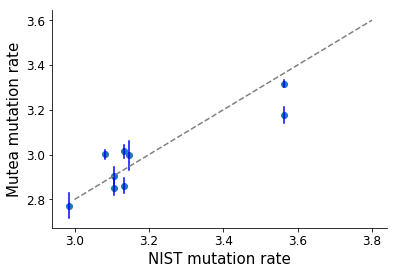

In [6]:
# Mutea CODIS estimates vs. NIST reported
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(codis["mutrate_scale"].apply(lambda x: -1*np.log10(x)),
          codis["log10mu"]*-1);
for i in range(codis.shape[0]):
    xval = codis["mutrate_scale"].apply(lambda x: -1*np.log10(x)).values[i]
    mean = -1*codis["log10mu"].values[i]
    se = codis["log10mu_se"].values[i]
    ax.plot([xval,xval],[mean-1.96*se,mean+1.96*se], color="blue")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("NIST mutation rate", size=15)
ax.set_ylabel("Mutea mutation rate", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.plot([3.0,5.0],[3.0,5.0], linestyle="dashed", color="gray")
scipy.stats.pearsonr(codis["mutrate_scale"].apply(lambda x: -1*np.log10(x)), codis["log10mu"]*-1)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


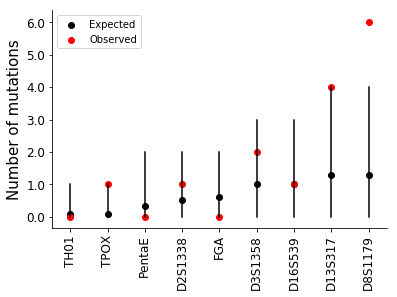

In [7]:
# Look at denovos vs. reported CODIS rate

nsim=100000
# Get expected num mutations for each marker
codis["codis_exp"] = codis.apply(lambda x: x["mutrate"]*x["total_children"], 1)
codis["codis_se"] = codis.apply(lambda x: np.sqrt(np.var(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim))), 1)
codis["codis_low"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 2.5), 1)
codis["codis_high"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 97.5), 1)
codis["pval"] = codis.apply(lambda x: np.mean([item>=x["total_mutations"] for item in np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim)]), 1)
#codis[["chrom","pos","marker","mutrate","pval","codis_exp","codis_low","codis_high","total_children","total_mutations"]]

fig = plt.figure()
ax = fig.add_subplot(111)
codis = codis.sort("codis_exp")
codis["order"] = range(codis.shape[0])
ax.scatter(codis["order"], codis["codis_exp"], color="black", label="Expected")
for i in range(codis.shape[0]):
    x = codis["order"].values[i]
    low = codis["codis_low"].values[i]
    high = codis["codis_high"].values[i]
    obs = codis["total_mutations"].values[i]
    ax.plot([x,x],[low,high], color="black")
    if i==0: ax.scatter([x],[obs], color="red", label="Observed")
    else: ax.scatter([x],[obs], color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(codis["order"])
ax.set_xticklabels(codis["marker"], rotation=90, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Number of mutations", size=15)
ax.legend(loc="upper left")

In [8]:
codis

,chrom,pos,end,log10mu,beta,pgeom,log10mu_se,nsamples,end_x,marker,...,motif,strconsDIFF,strconsZ,mutrate_scale,codis_exp,codis_se,codis_low,codis_high,pval,order
5,11,2192318,2192345,-3.939723,0.476766,0.809625,0.044894,957,2192345,TH01,...,AATG,1.8091774361420343,0.7511471986986287,0.000039,0.0904,0.299851,0.0,1.0,1.00000,0
0,2,1493425,1493456,-4.292870,0.017358,0.925454,0.022068,957,1493456,TPOX,...,AATG,0.5476749158379057,0.21841633661719406,0.000039,0.0908,0.303917,0.0,1.0,0.08624,1
7,15,97374244,97374269,-3.502246,0.052082,0.700026,0.026717,956,97374269,PentaE,...,AAAAG,3.6927373413676494,1.4700218417256625,0.000624,0.3264,0.571297,0.0,2.0,1.00000,2
1,2,218879582,218879673,-3.535825,0.100019,0.700027,0.035138,957,218879673,D2S1338,...,AAGG,-0.02215000097097992,-0.008931636055695247,0.000468,0.5136,0.713014,0.0,2.0,0.40294,3
3,4,155508888,155508975,-2.930697,0.262612,0.761571,0.069715,945,155508975,FGA,...,AAAG,1.2350837302059838,0.5150963763850118,0.001091,0.5992,0.770831,0.0,2.0,1.00000,4
2,3,45582231,45582294,-3.154153,0.231933,0.990216,0.042341,957,45582294,D3S1358,...,AGAT,0.6938604472817173,0.28055254940858765,0.000468,1.0104,1.007619,0.0,3.0,0.26975,5
8,16,86386308,86386351,-3.491789,0.248477,1.000000,0.082664,952,86386351,D16S539,...,AGAT,1.0665669252265146,0.48090026384289075,0.000429,1.0120,1.006888,0.0,3.0,0.63656,6
6,13,82722160,82722203,-3.133074,0.204294,0.919489,0.042550,950,82722203,D13S317,...,AGAT,2.078188116522444,0.8402277902128907,0.000546,1.2768,1.129400,0.0,4.0,0.04129,7
4,8,125907107,125907158,-3.264041,0.305561,0.775821,0.048530,956,125907158,D8S1179,...,AGAT,1.7303932858866495,0.7095431554328906,0.000546,1.3020,1.137957,0.0,4.0,0.00210,8
